In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.utils import resample
import os
from asn.evaluation.metrics import obtainTargetLatency

colors = sns.color_palette(sns.xkcd_palette(["orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

result_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/ModelEvaluation/'
figure_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/Figures/'

filename = result_path + 'RTs_150620.pkl'
conds = ['P-1_I-0_O-0.3', 'P-0_I-0_O-0.3', 'P-1_I-0.15_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0.05_O-0.2', 'P-0_I-0.05_O-0.2',
         'P-1_I-0_O-0', 'P-0_I-0_O-0']

save = False
if not os.path.exists(filename):
    tracker_I = joblib.load(result_path + 'Performance_inputGain_100620.pkl')
    tracker_PI = joblib.load(result_path + 'Performance_inputGainPrecision_150620.pkl')
    tracker_O = joblib.load(result_path + 'Performance_outputGain_040620.pkl')
    tracker_PO = joblib.load(result_path + 'Performance_outputGainPrecision_040620.pkl')
    tracker_x = joblib.load(result_path + 'Performance_interactions_150620.pkl') 
    tracker_Px = joblib.load(result_path + 'Performance_interactionsPrecision_150620.pkl')

    trials = tracker_I['num_samples']
    RTs = pd.DataFrame(np.full((len(conds) * 2 * trials, 7), np.nan),
                       columns=['Model', 'Precision', 'Input gain', 'Output gain', 'Attention', 'Trial', 'RT'])

    RTs['Attention'] = np.repeat(np.arange(2)[np.newaxis, :], len(conds) * trials, axis=0).flatten()
    RTs['Model'] = np.repeat(np.arange(len(conds))[np.newaxis, :], 2 * trials, axis=1).flatten()
    RTs['Trial'] = np.repeat(np.arange(trials)[np.newaxis, :], 2 * len(conds), axis=0).flatten()

    replace_map = {'Attention': {0: 'valid', 1: 'invalid'}}
    RTs.replace(replace_map, inplace=True)

    # %% Target time course modulation plot
    num_draws = 500  # 50#500
    np.random.seed(3)
    idx = np.arange(trials)

    onset = 100
    time_steps = np.arange(0, 650)
    target_idx = np.where(tracker_I['y_train_single'] == 1)
    non_target_idx = np.where(tracker_I['y_train_single'] == 0)
    baseline = tracker_O['mf_0.45']['predictions']

    sns.set_context("poster")
    fig, ax = plt.subplots(4, 2, figsize=(13, 16), sharey=True, sharex=True)
    ax = ax.flatten()

    for c in range(len(conds)):
        cond = conds[c]
        print(cond)
        splits = cond.split('_')

        RTs.loc[RTs['Model'] == c, 'Precision'] = float(splits[0].split('-')[1])
        RTs.loc[RTs['Model'] == c, 'Input gain'] = float(splits[1].split('-')[1])
        RTs.loc[RTs['Model'] == c, 'Output gain'] = float(splits[2].split('-')[1])

        RTs.loc[RTs['Model'] == c, 'Model'] = cond

        if (float(splits[0].split('-')[1]) == 0) & (float(splits[1].split('-')[1]) >= 0) & (
                float(splits[2].split('-')[1]) == 0):
            tracker = tracker_I
        elif (float(splits[0].split('-')[1]) == 1) & (float(splits[1].split('-')[1]) >= 0) & (
                float(splits[2].split('-')[1]) == 0):
            tracker = tracker_PI
        elif (float(splits[0].split('-')[1]) == 0) & (float(splits[1].split('-')[1]) == 0) & (
                float(splits[2].split('-')[1]) >= 0):
            tracker = tracker_O
        elif (float(splits[0].split('-')[1]) == 1) & (float(splits[1].split('-')[1]) == 0) & (
                float(splits[2].split('-')[1]) > 0):
            tracker = tracker_PO
        elif (float(splits[0].split('-')[1]) == 0) & (float(splits[1].split('-')[1]) > 0) & (
                float(splits[2].split('-')[1]) > 0):
            tracker = tracker_x
        elif (float(splits[0].split('-')[1]) == 1) & (float(splits[1].split('-')[1]) > 0) & (
                float(splits[2].split('-')[1]) > 0):
            tracker = tracker_Px
        else:
            raise (ValueError('This is not defined'))

        for i, att in enumerate(['valid', 'invalid']):
            RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == att), 'RT'] = obtainTargetLatency(
                tracker['attention_0.45'][cond][att]['predictions'], tracker['y_train_single'],
                offset=tracker['start_eval'])

            modulation = tracker['attention_0.45'][cond][att]['predictions'][:, onset:, :] - baseline[:, onset:,
                                                                                                     :]
            # bootstrap the 95%CI for every time point
            mean_draws_t = list()
            mean_draws_o = list()
            for d in range(num_draws):
                # Resampling, with replacement, taking the class imbalance into account
                draw = resample(idx, n_samples=trials, random_state=d, stratify=tracker['y_train_single'])
                mean_draws_t.append(np.mean(modulation[target_idx[0][draw], :, target_idx[1][draw]], axis=0))
                mean_draws_o.append(np.mean(modulation[non_target_idx[0][draw], :, non_target_idx[1][draw]], axis=0))

            ax[c].axhline(0, color=colors[2])

            ax[c].plot(time_steps, np.mean(modulation[target_idx[0], :, target_idx[1]], axis=0),
                               color=colors[i])

            ax[c].fill_between(time_steps, np.percentile(mean_draws_t,2.5, axis=0),
                               np.percentile(mean_draws_t, 97.5, axis=0),
                               color=colors[i], alpha=0.4)

            ax[c].plot(time_steps, np.mean(modulation[non_target_idx[0], :, non_target_idx[1]], axis=0),
                               color=colors[i],
                               ls='--')
            ax[c].fill_between(time_steps, np.percentile(mean_draws_o, 2.5, axis=0),
                               np.percentile(mean_draws_o, 97.5, axis=0),
                               color=colors[i], alpha=0.4)

            sns.despine(ax=ax[c])
    ax[0].set_ylabel('Connection gain')
    ax[0].set_xlabel(' ')
    ax[0].set_title('With precision')

    ax[1].set_title('Without precision')
    ax[1].set_xlabel(' ')

    ax[2].set_ylabel('Input gain')
    ax[2].set_xlabel(' ')

    ax[3].set_xlabel(' ')

    ax[4].set_ylabel('Input &\nconnection gain')
    ax[4].set_xlabel(' ')
    ax[5].set_xlabel(' ')

    ax[6].set_ylabel('Without gain')
    ax[6].set_xlabel('Time (ms)')

    ax[7].set_xlabel('Time (ms)')
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.tight_layout()
    if save == True:
        fig.savefig(figure_path + 'Modulation_allConditions.pdf', dpi=300, transparent=True)
    else:
        plt.show()

    del tracker_I, tracker_PI, tracker_O, tracker_PO, tracker_x, tracker_Px

    # Save the results
    RTs.to_pickle(filename)

else:
    RTs = pd.read_pickle(filename)

Using TensorFlow backend.


1097
913
1064
928


1046
935
1025
953


1088
913
1060


929
1022
969


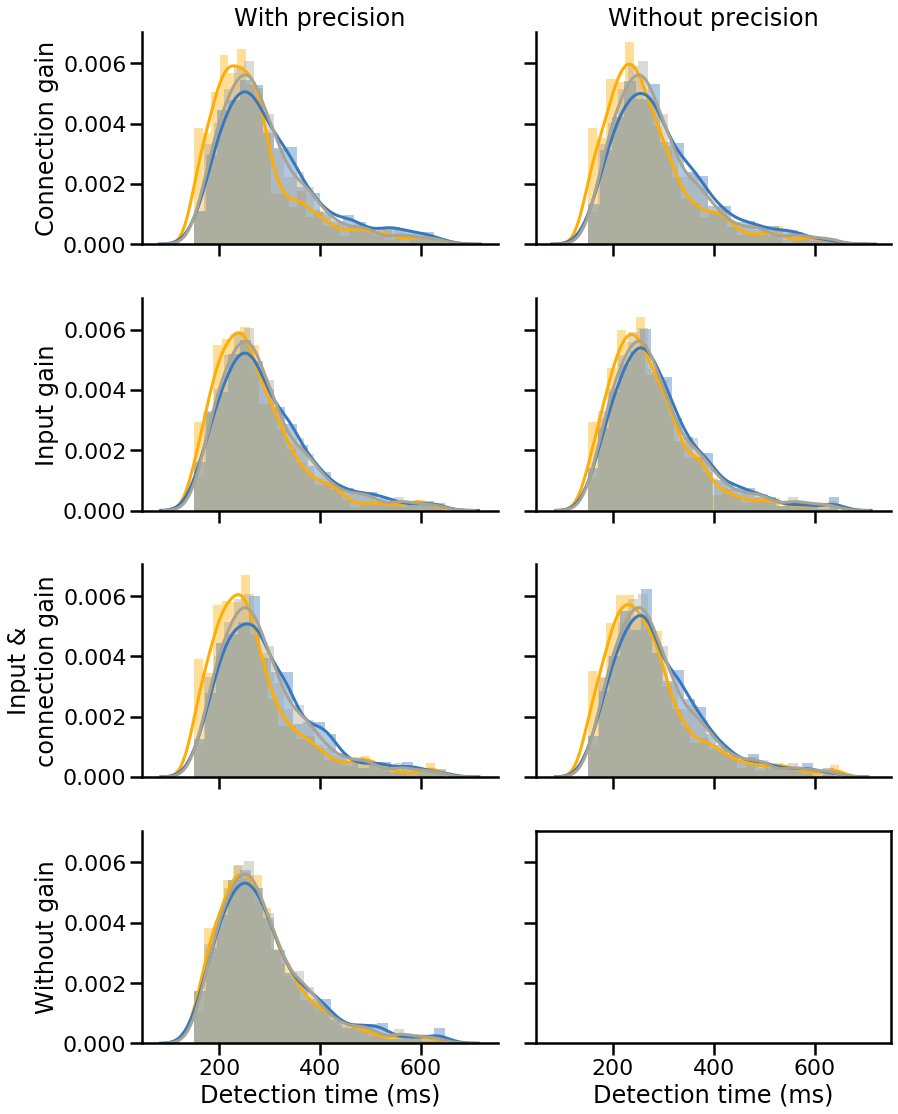

In [2]:
offset = 0
onset = 100

time_steps = np.arange(-onset, 750 - onset)

sns.set_context("poster")
fig, ax = plt.subplots(4,2, figsize=(13, 16), sharey=True, sharex=True)

ax = ax.flatten()

for c, cond in enumerate(conds[:-1]):
    for i, att in enumerate(['valid', 'invalid']):
        print(np.sum(RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == att), 'RT'] > 0))
        sns.distplot(RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == att), 'RT'] - 100, color=colors[i], ax=ax[c])
        sns.despine(ax=ax[c])
    sns.distplot(RTs.loc[(RTs['Model'] == 'P-0_I-0_O-0') & (RTs['Attention'] == 'valid'), 'RT'] - 100, color=colors[2],
                 ax=ax[c])

ax[0].set_ylabel('Connection gain')
ax[0].set_xlabel(' ')
ax[0].set_title('With precision')

ax[1].set_title('Without precision')
ax[1].set_xlabel(' ')

ax[2].set_ylabel('Input gain')
ax[2].set_xlabel(' ')

ax[3].set_xlabel(' ')

ax[4].set_ylabel('Input &\nconnection gain')
ax[4].set_xlabel(' ')
ax[5].set_xlabel(' ')

ax[6].set_ylabel('Without gain')
ax[6].set_xlabel('Detection time (ms)')

ax[7].set_xlabel('Detection time (ms)')
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'DetectionTimes_allConditions_neutral.pdf', dpi=300, transparent=True)
else:
    plt.show()


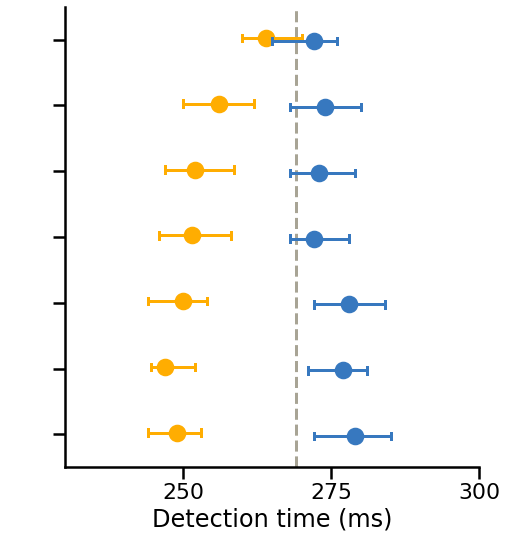

In [3]:
medians = RTs.groupby(['Model', 'Attention'])['RT'].median() - onset

RTs['RT_onset'] = RTs['RT'] - onset

order = ['P-1_I-0_O-0.3','P-1_I-0.05_O-0.2', 'P-0_I-0_O-0.3','P-0_I-0.05_O-0.2','P-1_I-0.15_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0_O-0']
sns.set_context("poster")

mode = 'points_h'
if mode == 'bars':
    # make a bar plot with the average FR in Hz
    g = sns.catplot(x="Model", y="RT_onset", hue="Attention", data=RTs[RTs['Model']!='P-0_I-0_O-0'],
                    height=8, aspect=2.2, kind="bar", palette={'valid': colors[0],'invalid': colors[1], 'neutral': colors[2] },
                    legend=False, estimator=np.median, order=order)
elif mode == 'points':
    dodge = True
    capsize = 0.1
    aspect = 1.85
    # amber, orange yellow

    g = sns.catplot(x="Model", y="RT_onset", hue="Attention", data=RTs[RTs['Model'] != 'P-0_I-0_O-0'],
                    height=8, aspect=aspect, kind="point",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, estimator=np.median, zorder=6, order=order, join=False, dodge=dodge,
                    capsize=capsize, errwidth=3)

elif mode == 'points_h':
    dodge = True
    capsize = 0.1
    aspect = 1.2
    errwidth = 3
    order = ['P-1_I-0_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0.15_O-0', 'P-0_I-0.05_O-0.2', 'P-0_I-0_O-0.3', 'P-1_I-0.05_O-0.2',
             'P-1_I-0_O-0.3']

    g = sns.catplot(y="Model", x="RT_onset", hue="Attention", data=RTs[RTs['Model'] != 'P-0_I-0_O-0'],
                    height=8, aspect=aspect, kind="point",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, estimator=np.median, zorder=6, order=order, join=False, dodge=dodge,
                    capsize=capsize, errwidth=3, orient='h')

    g.set_yticklabels([' ', ' ', ' \n ', ' \n ', ' ',
                       ' \n ', '  \n '])

    mean = np.nanmedian(RTs.loc[RTs['Model'] == 'P-0_I-0_O-0', 'RT']) - onset

    limits = np.array([230, 300])
    plt.xlim(limits)
    g.ax.set_xlabel('Detection time (ms)')
    g.ax.set_ylabel(' ')
    g.ax.set_xticks([250, 275, 300])

    g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)


    sns.despine(top=True, right=True)
    if save == True:
        g.savefig(figure_path + 'DetectionTimes_' + mode + '.pdf', dpi=300, transparent=True)
    else:
        plt.show()

else:
    raise ValueError("Not implemented.")





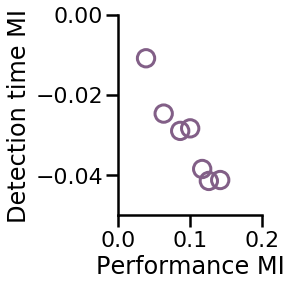

In [4]:
performance = pd.read_pickle(result_path + 'Performance_150620_bootstrap.pkl')
means_AUC = performance.groupby(['Model', 'Attention']).mean().reset_index()
medians = RTs.groupby(['Model', 'Attention'])['RT'].median().reset_index()

AI = pd.DataFrame(np.zeros((len(order) - 1, 3)), columns=['Model', 'Perf-AMI', 'DT-AMI'])

for c, cond in enumerate(order):
    AI.loc[c, 'Model'] = cond
    validDT = medians.loc[(medians['Model'] == cond) & (medians['Attention'] == 'valid'), 'RT'].values
    invalidDT = medians.loc[(medians['Model'] == cond) & (medians['Attention'] == 'invalid'), 'RT'].values
    AI.loc[c, 'DT-AMI'] = (validDT - invalidDT) / (validDT + invalidDT)

    validAUC = means_AUC.loc[(means_AUC['Model'] == cond) & (means_AUC['Attention'] == 'valid'), 'Analog performance range'].values
    invalidAUC = means_AUC.loc[(means_AUC['Model'] == cond) & (means_AUC['Attention'] == 'invalid'), 'Analog performance range'].values
    AI.loc[c, 'Behaviour-AMI'] = (validAUC - invalidAUC) / (validAUC + invalidAUC)


fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.scatter(AI['Behaviour-AMI'],AI['DT-AMI'],facecolors='none', edgecolor=colors[4], s=300, linewidths= 3)
ax.set_xlabel('Performance MI')
ax.set_ylabel('Detection time MI')
ax.set_xlim([0,0.2])
ax.set_ylim([-0.05,0])
sns.despine()
ax.set_yticks([0, -0.02, -0.04])
ax.set_xticks([0, 0.1, 0.2])
plt.tight_layout()

if save == True:
    fig.savefig(figure_path + 'Behaviour_AMI_high.pdf', dpi=300, transparent=True)
else:
    plt.show()


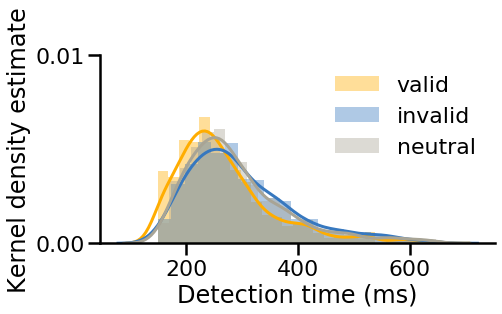

In [5]:
cond = 'P-0_I-0_O-0.3'
fig, ax = plt.subplots(figsize=(7.5,4.5))
sns.distplot(RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == 'valid'), 'RT'] - onset, color=colors[0],label='valid', ax=ax)
sns.distplot(RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == 'invalid'), 'RT'] - onset, color=colors[1], label='invalid',ax=ax)
sns.distplot(RTs.loc[(RTs['Model'] == 'P-0_I-0_O-0') & (RTs['Attention'] == 'valid'), 'RT'] - onset, color=colors[2], label='neutral', ax=ax)
sns.despine()
ax.set_xlabel('Detection time (ms)')
ax.set_ylabel('Kernel density estimate')
ax.set_yticks([0, 0.01])
plt.legend(frameon=False)
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'DetectionTime_example_flat.pdf', dpi=300, transparent=True)
else:
    plt.show()


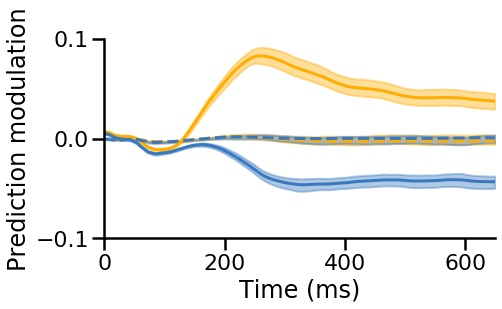

In [8]:
splits = cond.split('_')

if (float(splits[0].split('-')[1]) == 0) & (float(splits[1].split('-')[1]) >= 0) & (
        float(splits[2].split('-')[1]) == 0):
    tracker = joblib.load(result_path + 'Performance_inputGain_100620.pkl')
elif (float(splits[0].split('-')[1]) == 1) & (float(splits[1].split('-')[1]) >= 0) & (
        float(splits[2].split('-')[1]) == 0):
    tracker = joblib.load(result_path + 'Performance_inputGainPrecision_150620.pkl')
elif (float(splits[0].split('-')[1]) == 0) & (float(splits[1].split('-')[1]) == 0) & (
        float(splits[2].split('-')[1]) >= 0):
    tracker = joblib.load(result_path + 'Performance_outputGain_040620.pkl')
elif (float(splits[0].split('-')[1]) == 1) & (float(splits[1].split('-')[1]) == 0) & (
        float(splits[2].split('-')[1]) > 0):
    tracker = joblib.load(result_path + 'Performance_outputGainPrecision_040620.pkl')
elif (float(splits[0].split('-')[1]) == 0) & (float(splits[1].split('-')[1]) > 0) & (
        float(splits[2].split('-')[1]) > 0):
    tracker = joblib.load(result_path + 'Performance_interactions_150620.pkl') 
elif (float(splits[0].split('-')[1]) == 1) & (float(splits[1].split('-')[1]) > 0) & (
        float(splits[2].split('-')[1]) > 0):
    tracker = joblib.load(result_path + 'Performance_interactionsPrecision_150620.pkl')
else:
    raise (ValueError('This is not defined'))

baseline = tracker['mf_0.45']['predictions']
num_draws = 500

target_idx = np.where(tracker['y_train_single'] == 1)
non_target_idx = np.where(tracker['y_train_single'] == 0)
idx = np.arange(tracker['num_samples'])
fig, ax = plt.subplots(figsize=(7.5, 4.5))
for i, att in enumerate(['valid', 'invalid']):

    modulation = tracker['attention_0.45'][cond][att]['predictions'][:, onset:, :] - baseline[:, onset:,
                                                                                     :]
    # bootstrap the 95%CI for every time point
    mean_draws_t = list()
    mean_draws_o = list()

    for d in range(num_draws):
        # Resampling, with replacement, taking the class imbalance into account
        draw = resample(idx, random_state=d, stratify=tracker['y_train_single'])
        mean_draws_t.append(np.mean(modulation[target_idx[0][draw], :, target_idx[1][draw]], axis=0))
        mean_draws_o.append(np.mean(modulation[non_target_idx[0][draw], :, non_target_idx[1][draw]], axis=0))

    ax.plot(np.arange(650), np.mean(modulation[target_idx[0], :, target_idx[1]], axis=0),
            color=colors[i], label='Target' + ' &\n' + att + ' Cue')

    ax.fill_between(np.arange(650), np.percentile(mean_draws_t, 2.5, axis=0),
                    np.percentile(mean_draws_t, 97.5, axis=0),
                    color=colors[i], alpha=0.4)

    ax.plot(np.arange(650), np.mean(modulation[non_target_idx[0], :, non_target_idx[1]], axis=0),
            color=colors[i], ls='--', label='No target' + ' &\n' + att + ' Cue')
    ax.fill_between(np.arange(650), np.percentile(mean_draws_o, 2.5, axis=0),
                    np.percentile(mean_draws_o, 97.5, axis=0),
                    color=colors[i], alpha=0.4)
sns.despine()
ax.set_ylabel('Prediction modulation')
ax.set_xlabel('Time (ms)')
ax.set_ylim([-0.1, 0.1])
ax.set_xlim([0, 650])
ax.set_yticks([-0.1, 0, 0.1])
plt.tight_layout()

if save == True:
    fig.savefig(figure_path + 'Modulation_example_flat.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [ ]:
import random

conds = ['P-0_I-0.05_O-0.2', 'P-0_I-0.15_O-0','P-0_I-0_O-0.3', 'P-1_I-0.05_O-0.2', 'P-1_I-0.15_O-0', 'P-1_I-0_O-0', 'P-1_I-0_O-0.3']

comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])
neutralRTs = RTs.loc[(RTs['Model'] == 'P-0_I-0_O-0') & (RTs['Attention'] == 'valid'),'RT']

idx = np.arange(len(neutralRTs)*2)
# Define p (number of permutations):
p = 1000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for cond in conds:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validRTs = RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == 'valid'), 'RT']

    invalidRTs =  RTs.loc[(RTs['Model'] == cond) & (RTs['Attention'] == 'invalid'), 'RT']

    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.nanmedian(validRTs) - np.nanmedian(invalidRTs))
                samplePreds = np.concatenate([validRTs, invalidRTs], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.nanmedian(validRTs) - np.nanmedian(neutralRTs))

                samplePreds = np.concatenate([validRTs, neutralRTs], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.nanmedian(invalidRTs) - np.nanmedian(neutralRTs))
                samplePreds = np.concatenate([invalidRTs, neutralRTs], axis=0)

            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.nanmedian(samplePreds[idx[:int(len(idx)//2)]]) - np.nanmedian(samplePreds[idx[int(len(idx)//2):]])))


            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append(
                {'Mechanism': cond, 'Comparison': comp, 'Difference': diff, 'p-values': p_val,
                 'significant': p_val < results['alpha-level']}, ignore_index=True)

joblib.dump(results, result_path + 'RT_PermutationTestsComparisons.pkl', compress=True)
results_df.to_csv(result_path + 'RT_PermutationTestsComparisons_df.csv')